In [360]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [361]:
ecg_sample = np.loadtxt('./output/ecg_sample_750hz.csv', delimiter=',')
w_sample = np.loadtxt('./output/w_sample_750hz.csv', delimiter=',')

In [362]:
%matplotlib widget

class InterfaceManager(object):
    def __init__(self):
        self.ecg_sample = ecg_sample
        self.w_sample = w_sample
        self.fig, self.axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

        ax = self.axs[0, 0]
        ax.plot(*ecg_sample.T)
        ax.set_xlim(auto=False); ax.set_ylim(auto=False)

        self.parasol_ecg, = ax.fill(
            [1.5, 1.5, 10, 10], [-10, 10, 10, -10],
            linewidth=1, color='#ffffff', alpha=0.8, zorder=4
        )

        ax = self.axs[0, 1]
        self.pcloud, = ax.plot(ecg_sample[:-4, 1], ecg_sample[4:, 1], linestyle='--', linewidth=1, marker='.', markersize=10)
        ax.set_xlim(auto=False); ax.set_ylim(auto=False)

        self.parasol_ebd, = ax.fill(
            [10, 0.5, 0, 0, 0.5, 0.5, 10, 10, -10, -10, 10, ],
            [10, 0.5, 0.5, 0, 0, 0.5, 10, -10, -10, 10, 10, ],
            linewidth=0, color='#000000', alpha=0.2, zorder=4
        )

        ax = self.axs[1, 1]
        self.txt_wsum = ax.text(0.5, 0.5, 'drag please', fontsize=20)

        self.fig.canvas.mpl_connect('button_press_event', self.on_button_press)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion_notify)
        self.fig.canvas.mpl_connect('button_release_event', self.on_button_release)

        plt.show()
    
    def __exit__(self, exception_type, exception_value, traceback):
        plt.close()

    def on_button_press(self, event):
        if event.inaxes is self.axs[0, 0]:
            pass
            # self.interval_end = event.xdata
        elif event.inaxes is self.axs[0, 1]:
            self.box_corner = (event.xdata, event.ydata)
    
    def on_motion_notify(self, event):
        if event.button is None:
            return
        if event.inaxes is self.axs[0, 0]:
            self.set_interval_end(event)
            self.set_txt_wsum(event)
        elif event.inaxes is self.axs[0, 1]:
            self.set_box(event)
            self.set_txt_wsum(event)
    
    def on_button_release(self, event):
        if event.inaxes is self.axs[0, 0]:
            pass
            # delattr(self, 'interval_end')
        elif event.inaxes is self.axs[0, 1]:
            delattr(self.box_corner)

    def set_interval_end(self, event):
        xy = self.parasol_ecg.get_xy()
        xy[:2, 0] = event.xdata
        self.parasol_ecg.set_xy(xy)

    # def set_cloud(self, event):
    #     xy = self.pcloud.get_paths()[0].vertices
        

    def set_box(self, event):
        xy = self.parasol_ebd.get_xy()
        box_x = sorted([self.box_corner[0], event.xdata])
        box_y = sorted([self.box_corner[1], event.ydata])
        xy[1:6] = np.array([
            [box_x[1], box_y[1]], 
            [box_x[0], box_y[1]],
            [box_x[0], box_y[0]], 
            [box_x[1], box_y[0]], 
            [box_x[1], box_y[1]],
        ])
        self.parasol_ebd.set_xy(xy)

    def set_txt_wsum(self, event):
        npts = sum(self.ecg_sample[:, 0] < self.get_interval_end())
        x, y = self.pcloud.get_data()
        box_x, box_y = self.get_box()
        mask = (x >= box_x[0]) & (x <= box_x[1]) & (y >= box_y[0]) & (y <= box_y[1])
        wsum = np.sum(self.w_sample[npts, mask])
        self.txt_wsum.set_text(f'{wsum:.5f}')
        
    def get_interval_end(self):
        return self.parasol_ecg.get_xy()[0, 0]
    
    def get_box(self):
        xy = self.parasol_ebd.get_xy()
        return xy[3:5, 0], xy[4:6, 1]


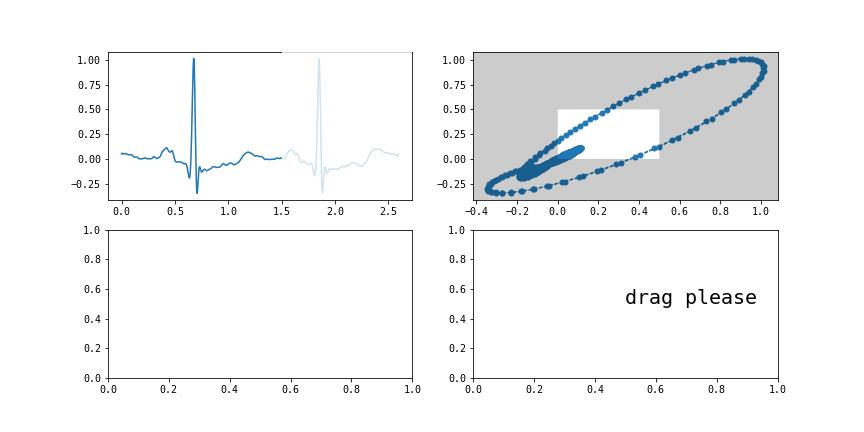

In [363]:
ifm = InterfaceManager()

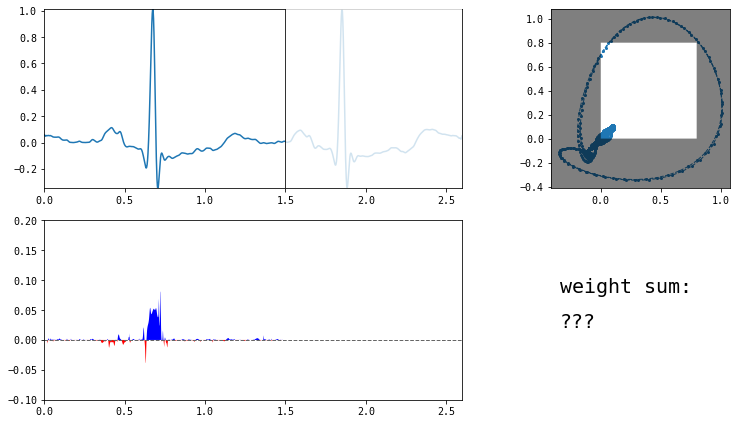

In [497]:
%matplotlib inline
import mpld3

class Framer(mpld3.plugins.PluginBase):
    JAVASCRIPT = """
    mpld3.register_plugin("framer", Framer);
    Framer.prototype = Object.create(mpld3.Plugin.prototype);
    Framer.prototype.constructor = Framer;
    Framer.prototype.requiredProps = ["fig_id"];
    function Framer(fig, props) {
        mpld3.Plugin.call(this, fig, props);
    };

    Framer.prototype.draw = function() {
        let div_outer = d3.select("#" + this.props.fig_id);
        div_outer.select("div").
            attr("id", "div-old");
        let transform = "translate(0, 0)";
        
        for (let i=1; i<=4; i++) {
            let to_copy = d3.select("#div-old")
                .select("svg").select("g");
            if (i == 1) {
                transform = to_copy.attr("transform");
            }
            d3.select("body")
                .attr("style", "white-space: nowrap;")
                .insert("div", "#" + this.props.fig_id)
                .attr("id", "subplt-22" + i)
                .classed("subplt", true)
                .attr("style", "display: inline;")
                .append("svg")
                .attr("width", "432")
                .attr("height", "232")
                .attr("id", "svg-22" + i)
                .attr("class", "mpld3-figure")
                .append(() => to_copy.node())
                .attr("transform", transform);
            if (i == 2) {
                d3.select("body").insert("br", "#" + this.props.fig_id);
            }
        }
        div_outer.remove();

    }

    mpld3.register_plugin("framer", Framer);
    """

    def __init__(self, fig_id='div-outermost'):
        self.dict_ = {
            'type': 'framer', 
            'fig_id': fig_id
        }

class SetInterval(mpld3.plugins.PluginBase):
    JAVASCRIPT = """
    mpld3.register_plugin("set_interval", SetInterval);
    SetInterval.prototype = Object.create(mpld3.Plugin.prototype);
    SetInterval.prototype.constructor = SetInterval;
    SetInterval.prototype.requiredProps = ["cloud_ecg_id", "hole_id", "pcloud_id", "w_sample", "wbars_pos_id", "wbars_neg_id", "txt_obj_id"];
    function SetInterval(fig, props) {
        mpld3.Plugin.call(this, fig, props);
    };

    SetInterval.prototype.draw = function() {
        let txt_obj = mpld3.get_element(this.props.txt_obj_id)
        let ecg_cloud = mpld3.get_element(this.props.cloud_ecg_id);
        let svg_1 = d3.select("#svg-221");
        let offset = parseFloat(
            svg_1.select("g")
                .attr("transform")
                .split("(")[1]
                .split(",")[0]
        )

        let wbars_pos = mpld3.get_element(this.props.wbars_pos_id);
        let wbars_neg = mpld3.get_element(this.props.wbars_neg_id);
        let w_sample = this.props.w_sample

        for (let i=0; i<wbars_pos.data.length; i++) {
            wbars_pos.data[i][2] = 0;
            wbars_neg.data[i][1] = 0;
        }

        svg_1.on("mousedown", function() {
            update_interval()
            ecg_cloud.path.classed("dragging", true)
            })
            .on("mousemove", function() {
                if (!ecg_cloud.path.classed("dragging")) {
                    return
                }
                update_interval()
            })
            .on("mouseup", function() {
                ecg_cloud.path.classed("dragging", false);
            })

        function update_interval() {
            let pos = d3.mouse(svg_1.node());
            let new_x = ecg_cloud.ax.x.invert(pos[0] - offset);

            new_x = new_x - new_x % (10/750)
            new_x = new_x > 30/750 ? new_x : 30/750;
            new_x = new_x < (1900 / 750) ? new_x : (1900 / 750);

            let xy = ecg_cloud.data;
            xy[1][0] = new_x;
            xy[2][0] = new_x;
            
            ecg_cloud.path.attr("d", 
                ecg_cloud.datafunc(xy, ecg_cloud.pathcodes)
            );

            let idx = Math.floor((Math.round(new_x * 750)-30)/10);
            let wvec = w_sample[idx];
            for (let i=1; i<wbars_pos.data.length-1; i++) {
                wbars_pos.data[i][1] = wvec[i] > 0 ? wvec[i] : 0;
                wbars_neg.data[i][2] = wvec[i] < 0 ? wvec[i] : 0;
            }

            wbars_pos.path.attr("d",
                wbars_pos.datafunc(wbars_pos.data, wbars_pos.pathcodes)
            );
            wbars_neg.path.attr("d",
                wbars_neg.datafunc(wbars_neg.data, wbars_neg.pathcodes)
            );

            update_wsum();
        }


        let hole = mpld3.get_element(this.props.hole_id);
        let pcloud = mpld3.get_element(this.props.pcloud_id)
        let svg_2 = d3.select("#svg-222");
        let offset_x = parseFloat(
            svg_2.select("g")
                .attr("transform")
                .split("(")[1]
                .split(",")[0]
        );
        let offset_y = parseFloat(
            svg_2.select("g")
                .attr("transform")
                .split(",")[1]
                .split(")")[0]
        )
        let corner = [0, 0];

        svg_2.on("mousedown", function() {
            corner = d3.mouse(svg_2.node());
            corner[0] -= offset_x; corner[1] -= offset_y;
            update_hole()
            hole.path.classed("dragging", true)
            })
            .on("mousemove", function() {
                if (!hole.path.classed("dragging")) {
                    return
                }
                update_hole()
            })
            .on("mouseup", function() {
                hole.path.classed("dragging", false);
            })

        function update_hole() {
            let pos = d3.mouse(svg_2.node());
            pos[0] -= offset_x; pos[1] -= offset_y;
            let left = corner[0] < pos[0] ? corner[0] : pos[0];
            let right = corner[0] > pos[0] ? corner[0] : pos[0];
            let down = corner[1] > pos[1] ? corner[1] : pos[1];
            let up = corner[1] < pos[1] ? corner[1] : pos[1];
            left = hole.ax.x.invert(left); right = hole.ax.x.invert(right);
            down = hole.ax.y.invert(down); up = hole.ax.y.invert(up);
            
            let xy = hole.data;
            xy[1] = [left, down];
            xy[2] = [right, down];
            xy[3] = [right, up];
            xy[4] = [left, up];
            xy[5] = [left, down];
            
            hole.path.attr("d", 
                hole.datafunc(xy, hole.pathcodes)
            );

            update_wsum();

        }
        console.log(pcloud)
        function update_wsum() {
            let w_sum = 0;

            let left = hole.data[1][0];
            let right = hole.data[2][0];
            let up = hole.data[3][1];
            let down = hole.data[1][1];

            for (let i=0; i<pcloud.data.length-12; i++) {
                let x = pcloud.data[i][0];
                let y = pcloud.data[i][1];
                if ((x >= left) && (x <= right) && (y >= down) && (y <= up)) {
                    w_sum += wbars_pos.data[i][1] + wbars_neg.data[i][2];
                }
            }
            txt_obj.obj
                .text(w_sum.toFixed(5));
        }
    }

    mpld3.register_plugin("set_interval", SetInterval);
    """

    def __init__(self, cloud_ecg, hole, pcloud, w_sample, wbars_pos, wbars_neg, txt_obj):
        self.dict_ = {
            'type': 'set_interval',
            'cloud_ecg_id': mpld3.utils.get_id(cloud_ecg),
            'hole_id': mpld3.utils.get_id(hole),
            'pcloud_id': mpld3.utils.get_id(pcloud),
            'w_sample': w_sample[5::10].tolist(),
            'wbars_pos_id': mpld3.utils.get_id(wbars_pos),
            'wbars_neg_id': mpld3.utils.get_id(wbars_neg),
            'txt_obj_id': mpld3.utils.get_id(txt_obj)
        }


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

ax = axs[0, 0]
ax.autoscale(tight=True)
ax.plot(*ecg_sample.T)
ax.set_xlim(auto=False); ax.set_ylim(auto=False)
xlim = list(ax.get_xlim()); ylim = list(ax.get_ylim())
xlim[0] -= 0.1; xlim[1] += 0.1; ylim[0] -= 0.1; ylim[1] += 0.1
cloud_ecg, = ax.fill(
    [xlim[1]+0.1, 1.5, 1.5, xlim[1]+0.1, xlim[1]+0.1], 
    [ylim[0]-0.1, ylim[0]-0.1, ylim[1]+0.1, ylim[1]+0.1, ylim[0]-0.1], 
    color='#ffffff', alpha=0.8, linewidth=1, edgecolor='#000000', zorder=5)

ax = axs[0, 1]
pcloud, = ax.plot(ecg_sample[:-12, 1], ecg_sample[12:, 1], marker='.', markersize=4, linestyle='--', linewidth=1)
ax.set_aspect('equal')
ax.set_xlim(auto=False); ax.set_ylim(auto=False)
xlim = list(ax.get_xlim()); ylim = list(ax.get_ylim())
xlim[0] -= 0.1; xlim[1] += 0.1; ylim[0] -= 0.1; ylim[1] += 0.1
hole, = ax.fill(
    [xlim[0], 0, 0.8, 0.8, 0, 0, xlim[0], xlim[0], xlim[1], xlim[1], xlim[0]], 
    [ylim[0], 0, 0, 0.8, 0.8, 0, ylim[0], ylim[1], ylim[1], ylim[0], ylim[0]], 
    color='#000000', alpha=0.5, linewidth=0, zorder=4)

ax = axs[1, 0]
ax.set_xlim(axs[0, 0].get_xlim()); ax.set_ylim(-0.1, 0.2)
bar_x = (ecg_sample[:-24, 0] + ecg_sample[24:, 0]) / 2
nsteps = np.sum(ecg_sample[24:, 0] < 1.5)
wvec = w_sample[nsteps]
wvec[0] = 0
wbars_pos, = ax.fill(bar_x, np.maximum(0, w_sample[nsteps]), color='b', linewidth=0)
wbars_neg, = ax.fill(bar_x, np.minimum(0, w_sample[nsteps]), color='r', linewidth=0)
ax.hlines(xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], y=0, linewidth=1, color='#666666', linestyle='--')

ax = axs[1, 1]
ax.set_xticks([]); ax.set_yticks([])
ax.set_frame_on(False)
ax.set_aspect('equal')
ax.text(0.05, 0.6, 'weight sum:', fontsize=20)
txt_obj = ax.text(0.05, 0.4, '???', fontsize=20)

mpld3.plugins.connect(fig, Framer())
mpld3.plugins.connect(fig, SetInterval(cloud_ecg, hole, pcloud, w_sample, wbars_pos, wbars_neg, txt_obj))

mpld3.save_html(fig, './output/d3_html.html', figid="div-outermost")

plt.tight_layout()
plt.show(); plt.close()